In [1]:
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')

import frank_lab


In [2]:
fileroot = 'SampleData/Fra';
#fileroot = '/Users/ckemere/Development/Data/Frank/Fra';



In [3]:
[cellinfo,rawcellinfo] = frank_lab.load_data(fileroot, datatype='cellinfo')
#cellinfo[pd.isnull(cellinfo['area'])]
tetinfo,_ = frank_lab.load_data(fileroot, datatype='tetinfo')



Loading fracellinfo00.mat
Loading fratetinfo.mat


In [4]:
# These are all zero indexed in contrast to their matlab counterparts
Day = 4
Epoch = 5

TetrodeList = tetinfo.loc[tetinfo.Day==Day].loc[tetinfo.Epoch==Epoch].loc[tetinfo.area=='CA1'].Tetrode.tolist()

Tetrode = 9

task = frank_lab.load_data(fileroot, day=Day+1, datatype='task')
task[Day][Epoch].description


Loading fratask05.mat


'TrackA'

In [5]:
print(TetrodeList)
print(tetinfo.loc[tetinfo.Day==Day].loc[tetinfo.Epoch==Epoch].loc[tetinfo.area=='CA1'])


[0, 13, 5, 8, 9]
            Day  Tetrode  numcells area  depth  Epoch  representative  maxcell
(4, 5, 0)     4        0         6  CA1    123      5             NaN      NaN
(4, 5, 13)    4       13         2  CA1    111      5             NaN      NaN
(4, 5, 5)     4        5         0  CA1     99      5             NaN      NaN
(4, 5, 8)     4        8         1  CA1    114      5             NaN      NaN
(4, 5, 9)     4        9        11  CA1     98      5               1        1


In [6]:
eeg = frank_lab.load_data(fileroot, day=Day+1, epoch=Epoch+1, tetrode=TetrodeList[0]+1, version='new')

Loading fraeeg05-6-01.mat


In [7]:

# Now, want to generate synthetic data to mimic each tetrode, then detect ripples on them, 
# then generate the ROC plots using m of N rules
data = [frank_lab.load_data(fileroot, day=Day+1, epoch=Epoch+1, tetrode=t+1, version='new').data for t in TetrodeList]

eeg = frank_lab.load_data(fileroot, day=Day+1, epoch=Epoch+1, tetrode=TetrodeList[0]+1, version='new')
#eeg.__dict__ to get fields
#data = eeg.data
FS = eeg.samprate
StartTime = eeg.starttime
TimeAxis = StartTime + np.array(range(len(data))) / FS



Loading fraeeg05-6-01.mat
Loading fraeeg05-6-14.mat
Loading fraeeg05-6-06.mat
Loading fraeeg05-6-09.mat
Loading fraeeg05-6-10.mat
Loading fraeeg05-6-01.mat


In [8]:
pos = frank_lab.load_data(fileroot, day=Day+1, datatype='pos')


Loading frapos05.mat


In [9]:
# Maggie defines ripples by doing:
#  (1) filter 150-250
#  (2) hilbert envelope
#  (3) smooth with Gaussian (4 ms SD)
#  (4) 3SD above the mean for 15 ms
#  (5) full ripple defined as window back to mean

import ripples
RippleEvents = []
RippleSignal = []
SmoothedRippleEnvelope = []
for d in data:
    ripple_events, ripple_maxes, ripple_bounds, ripple_data, ripple_envelope, smoothed_envelope = \
        ripples.detect(d, FS=FS, ThresholdSigma=5)
    RippleEvents.append(ripple_events)
    RippleSignal.append(ripple_data)
    SmoothedRippleEnvelope.append(smoothed_envelope)


In [10]:
ripple_maxes.shape

(26,)

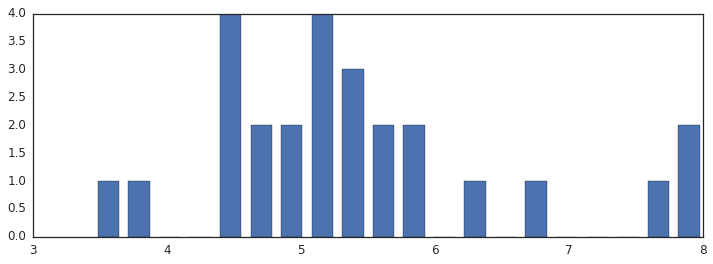

In [11]:
hist, bins = np.histogram(ripple_maxes/np.mean(smoothed_envelope), bins=20)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.bar(center, hist, align='center', width=width)
plt.show()


In [12]:
import scipy.ndimage
EnvelopeSmoothingSD = 0.004 * FS
b = signal.firwin(25, [150/(FS/2), 250/(FS/2)], pass_zero=False)

SynthRippleEnvelope = []

for k, r in enumerate(RippleSignal):
    # Generate a colored (i.e., filtered white) noise process with same mean and std as ripples
    normal_equivalent = np.random.randn(len(r));
    normal_equivalent_ripple = signal.filtfilt(b,1,normal_equivalent);
    normal_equivalent_ripple = normal_equivalent_ripple / np.std(normal_equivalent_ripple)
    normal_equivalent_ripple = normal_equivalent_ripple * np.std(r);
    ner_envelope = np.absolute(signal.hilbert(normal_equivalent_ripple))
    SynthRippleEnvelope.append(scipy.ndimage.filters.gaussian_filter1d(ner_envelope, EnvelopeSmoothingSD, mode='constant'))

    

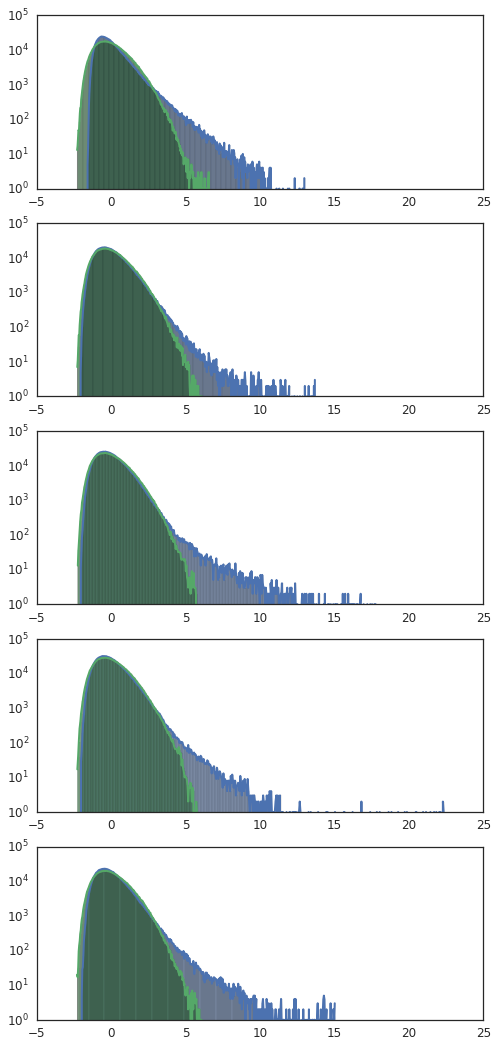

In [13]:
sns.set(rc={'figure.figsize': (8, 18),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')

from matplotlib import gridspec
gs = gridspec.GridSpec(len(TetrodeList), 1); 
firstsubplot = plt.subplot(gs[0])

NormalizedRipple = [(r - np.mean(r))/np.std(r) for r in SmoothedRippleEnvelope]
NormalizedSynth = [(r - np.mean(r))/np.std(r) for r in SynthRippleEnvelope]

for k, (r,s) in enumerate(zip(NormalizedRipple, NormalizedSynth)):
    # Compare histogram of envelope of synthetic and real ripples
    # Notice that the distribution of the real ripple data has a long tail (corresponding to actual SWR!)
    # We plot in terms of z-scores, though the actual numbers are probably also interesting...
    if (k > 0):
        plt.subplot(gs[k], sharex=firstsubplot)
    else:
        firstsubplot = plt.subplot(gs[k])

    
    bins=np.histogram(np.hstack((r, s)), bins=500)[1]; #get the bin edges
    h0, b, p0 = plt.hist(r,bins, alpha=0.5);
    h1, b, p1 = plt.hist(s, bins, alpha=0.5);
    plt.plot(bins[0:-1], h0, color=p0[0].get_facecolor(), alpha=1)
    plt.plot(bins[0:-1], h1, color=p1[0].get_facecolor(), alpha=1)
    plt.gca().set_yscale('log')


5.38565668622e-05


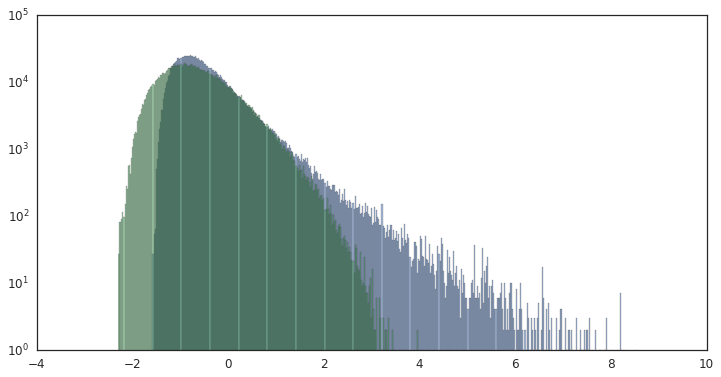

In [14]:
# What happens if we create a 15 ms sliding window. What is the histogram of the smallest z-scored smoothed envelope?
# The idea here is that a "ripple event" is defined as being greater than 3 SDs for 15 ms...
import scipy.ndimage
rip_window_mins = scipy.ndimage.filters.minimum_filter(NormalizedRipple[0], size=np.rint(FS*0.015), mode='reflect')
ner_window_mins = scipy.ndimage.filters.minimum_filter(NormalizedSynth[0], size=np.rint(FS*0.015), mode='reflect')

sns.set(rc={'figure.figsize': (12,6),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')


bins=np.histogram(np.hstack((rip_window_mins, ner_window_mins)), bins=500)[1]; #get the bin edges
h0, b, p0 = plt.hist(rip_window_mins,bins, alpha=0.5);
h1, b, p1 = plt.hist(ner_window_mins, bins, alpha=0.5);
plt.gca().set_yscale('log')

print(sum(ner_window_mins > 3)/len(ner_window_mins))

In [15]:
#plt.plot(data[-FS*3:-1])
#print(rip_events[-1,:])
#print(data.shape[0])

In [16]:
import functools
# Let's see what the "true positive" (i.e., number detected) and "false positive" rates are
# when we try different thresholds and window sizes

ExcursionWindows = np.arange(0.005,0.035,0.0025)
Thresholds = np.arange(2,7.25,0.25)

#ner_counts = np.zeros((len(ExcursionWindows),len(Thresholds)))
import time
t0 = time.time()
RipEvents = [[ripples.find_threshold_crossing_events(r, Thr)[0] for Thr in Thresholds] for r in NormalizedRipple]
t1 = time.time()
print("Elapsed time: {}".format(t1-t0))
SynthEvents = [[ripples.find_threshold_crossing_events(r, Thr)[0] for Thr in Thresholds] for r in NormalizedSynth]
t2 = time.time()
print("Elapsed time: {}".format(t2-t1))

Elapsed time: 38.335264921188354
Elapsed time: 32.519768714904785


In [80]:
len(RipEvents)

5

In [55]:
# Stack all the rip events in preparation for counting overlaps
t0 = time.time()
StackedRipEvents = RipEvents[0].copy()
StackedSynthEvents = SynthEvents[0].copy()
for k in range(1,len(TetrodeList)):
    for t in range(len(Thresholds)):
        StackedRipEvents[t] = RipEvents[k][t] if (StackedRipEvents[t].size == 0) else \
                    StackedRipEvents[t] if (RipEvents[k][t].size == 0) else \
                    np.vstack((StackedRipEvents[t], RipEvents[k][t]))
        StackedSynthEvents[t] = SynthEvents[k][t] if (StackedSynthEvents[t].size == 0) else \
                    StackedSynthEvents[t] if (SynthEvents[k][t].size == 0) else \
                    np.vstack((StackedSynthEvents[t], SynthEvents[k][t]))    
t1 = time.time()
print("Elapsed time: {}".format(t1-t0))

# Create a tetrode ID list for each event
StackedRipTetrodes = []
StackedSynthTetrodes = []
for th in range(len(Thresholds)):
    StackedRipTetrodes.append([[t] for t, E in enumerate(RipEvents) for _ in range(len(E[th])) ])
    StackedSynthTetrodes.append([[t] for t, E in enumerate(SynthEvents) for _ in range(len(E[th]))])
    
t2 = time.time()
print("Elapsed time: {}".format(t2-t1))

# Now, sort events by start time
for th in range(len(Thresholds)):
    if (StackedRipEvents[th].size > 0):
        sortidx = np.argsort(StackedRipEvents[th][:,0], axis=0)
        StackedRipTetrodes[th] = [StackedRipTetrodes[th][i] for i in sortidx]
        StackedRipEvents[th] = StackedRipEvents[th][sortidx,:]
    else:
        StackedRipEvents[th] = np.empty(shape=[0, 2])
    if (StackedSynthEvents[th].size > 0):    
        sortidx = np.argsort(StackedSynthEvents[th][:,0], axis=0)
        StackedSynthTetrodes[th] = [StackedSynthTetrodes[th][i] for i in sortidx]
        StackedSynthEvents[th] = StackedSynthEvents[th][sortidx,:]
    else:
        StackedSynthEvents[th] = np.empty(shape=[0, 2])


Elapsed time: 0.0032465457916259766
Elapsed time: 0.038802385330200195


In [41]:
X = np.empty(shape=[0, 2])

In [60]:
StackedSynthTetrodes[th]

[]

In [23]:
print(StackedSynthEvents[t])
print(SynthEvents[k][t])

[[32611 32621]]
[]


In [61]:
def intersect(r, s):
    if ((r[1] < s[0]) | (s[1] < r[0])):
        return np.array([])
    else:
        return np.array([np.min([r[0], s[0]]), np.max([r[1], s[1]])])

t0 = time.time()

RipEventList = []
RipEventTetrodes = []
SynthEventList = []
SynthEventTetrodes = []
for th in range(len(Thresholds)):
    if (StackedRipEvents[th].size > 0):
        RipEventList.append(np.atleast_2d(StackedRipEvents[th][0,:]))
        RipEventTetrodes.append([StackedRipTetrodes[th][0]])
        for k, ev in enumerate(StackedRipEvents[th][1:,:]):
            overlap = intersect(ev, RipEventList[th][-1])
            if (overlap.size == 0):
                RipEventList[th] = np.vstack((RipEventList[th],ev))
                RipEventTetrodes[th].append([StackedRipTetrodes[th][k]])
            else:
                RipEventList[th][-1,:] = overlap
                RipEventTetrodes[th][-1] += StackedRipTetrodes[th][k]
    else:
        RipEventList.append(np.empty(shape=[0, 2]))
        RipEventTetrodes.append([])


    if (StackedSynthEvents[th].size > 0):
        SynthEventList.append(np.atleast_2d(StackedSynthEvents[th][0,:]))
        SynthEventTetrodes.append([StackedSynthTetrodes[th][0]])
        for k, ev in enumerate(StackedSynthEvents[th][1:,:]):
            overlap = intersect(ev, SynthEventList[th][-1])
            if (overlap.size == 0):
                SynthEventList[th] = np.vstack((SynthEventList[th],ev))
                SynthEventTetrodes[th].append([StackedSynthTetrodes[th][k]])
            else:
                SynthEventList[th][-1,:] = overlap
                SynthEventTetrodes[th][-1] += StackedSynthTetrodes[th][k]
    else:
        SynthEventList.append(np.empty(shape=[0, 2]))
        SynthEventTetrodes.append([])

            
t1 = time.time()
print("Elapsed time: {}".format(t1-t0))


Elapsed time: 2.9233789443969727


In [62]:
RipEventList = [np.asarray(E) for E in RipEventList]
NumRipTetrodes = [np.asarray([len(NT) for NT in E]) for E in RipEventTetrodes]
SynthEventList = [np.asarray(E) for E in SynthEventList]
NumSynthTetrodes = [np.asarray([len(NT) for NT in E]) for E in SynthEventTetrodes]


In [68]:
NumSynthTetrodes[19]

array([], dtype=float64)

In [91]:

ExcursionWindows = np.arange(0.005,0.035,0.0025)

rip_counts_singletet = np.array([[np.sum(E[:,1] - E[:,0] >= np.round(FS*Win)) 
               if (E.size > 0) else 0 for Win in ExcursionWindows] 
               for E in RipEvents[4]])
ner_counts_singletet = np.array([[np.sum(E[:,1] - E[:,0] >= np.round(FS*Win)) 
               if (E.size > 0) else 0 for Win in ExcursionWindows] 
               for E in SynthEvents[4]])

rip_counts_atleast1 = np.array([[np.sum(E[NT>0,1] - E[NT>0,0] >= np.round(FS*Win)) 
               if (E.size > 0) else 0 for Win in ExcursionWindows] 
               for (E, NT) in zip(RipEventList, NumRipTetrodes)])
ner_counts_atleast1 = np.array([[np.sum(E[NT>0,1] - E[NT>0,0] >= np.round(FS*Win)) 
               if (E.size > 0) else 0 for Win in ExcursionWindows] 
               for (E, NT) in zip(SynthEventList, NumSynthTetrodes)])


rip_counts_atleast2 = np.array([[np.sum(E[NT>1,1] - E[NT>1,0] >= np.round(FS*Win)) 
               if (E.size > 0) else 0 for Win in ExcursionWindows] 
               for (E, NT) in zip(RipEventList, NumRipTetrodes)])
ner_counts_atleast2 = np.array([[np.sum(E[NT>1,1] - E[NT>1,0] >= np.round(FS*Win)) 
               if (E.size > 0) else 0 for Win in ExcursionWindows] 
               for (E, NT) in zip(SynthEventList, NumSynthTetrodes)])


rip_counts_atleast3 = np.array([[np.sum(E[NT>2,1] - E[NT>2,0] >= np.round(FS*Win)) 
               if (E.size > 0) else 0 for Win in ExcursionWindows] 
               for (E, NT) in zip(RipEventList, NumRipTetrodes)])
ner_counts_atleast3 = np.array([[np.sum(E[NT>2,1] - E[NT>2,0] >= np.round(FS*Win)) 
               if (E.size > 0) else 0 for Win in ExcursionWindows] 
               for (E, NT) in zip(SynthEventList, NumSynthTetrodes)])



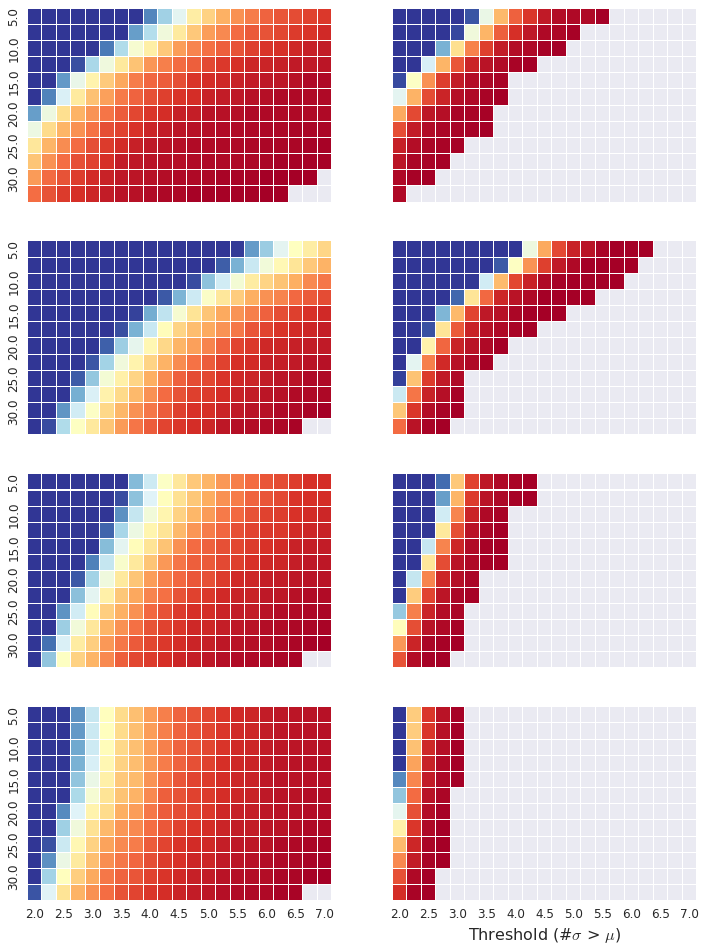

In [121]:
## from matplotlib import gridspec
import pandas as pd
sns.set_style('dark')
sns.set(rc={'figure.figsize': (12, 16),'lines.linewidth': 2, 'font.size': 18, 
            'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })


#gs = gridspec.GridSpec(4, 2); 

fig, axn = plt.subplots(4, 2, sharex=True, sharey=True)
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#cbar_ax = fig.add_axes([.91, .3, .03, .4])


datalist = [rip_counts_singletet, ner_counts_singletet, 
            rip_counts_atleast1, ner_counts_atleast1,
            rip_counts_atleast2, ner_counts_atleast2,
            rip_counts_atleast3, ner_counts_atleast3]

for i, ax in enumerate(axn.flat):
    df = pd.DataFrame(datalist[i].T / (len(data[0])/FS), index=ExcursionWindows*1000, columns=Thresholds)
    sns.heatmap(df, ax=ax, cbar=False, 
            mask=df<=0.0, cmap='RdYlBu', vmin=0, vmax=0.335,
            xticklabels=2, yticklabels=2, linewidths=.05);
    if (i%2 == 0):
        plt.yticks(rotation=0) # ylabels on left plots
        plt.ylabel('Window Criterion (ms)')
    if (i >= len(axn.flat)-2): # xlabels on bottom plots
        plt.xlabel('Threshold (#$\sigma$ > $\mu$)')


#fig.tight_layout(rect=[0, 0, .9, 1])


#ripvels = plt.subplot(gs[2]);
#vel3df = pd.DataFrame(rip_3vel_counts / rip_counts, index=ExcursionWindows, columns=Thresholds)
#sns.heatmap(vel3df, linewidths=.05, xticklabels=2, yticklabels=2, vmax=0.5, cmap='RdYlBu',mask=vel3df<=0);
#plt.yticks(rotation=0);

#ripvels = plt.subplot(gs[3]);
#vel10df = pd.DataFrame(rip_10vel_counts / rip_counts, index=ExcursionWindows, columns=Thresholds)
#sns.heatmap(vel10df, linewidths=.05, xticklabels=2, yticklabels=2, vmax=0.5, cmap='RdYlBu',mask=vel10df<=0);
#plt.yticks(rotation=0);




### Would like to add the fraction of ripples with greater than 3 cm/s velocity for each block
### as a second degree of info...



In [ ]:
ripple_events, ripple_maxes, ripple_bounds, ripple_signal, ripple_envelope, smoothed_envelope = \
    ripples.detect(data, FS=FS, ThresholdSigma=5)

gs = gridspec.GridSpec(1, 2); 
rip_positions = plt.subplot(gs[0]);
plt.plot(pos[Day][Epoch].data[:,1], pos[Day][Epoch].data[:,2])
rip_center_times = TimeAxis[np.rint((ripple_events[:,0] + ripple_events[:,1])/2).astype(int)]
RipIdx = np.searchsorted(pos[Day][Epoch].data[:,0], rip_center_times)
plt.plot(pos[Day][Epoch].data[RipIdx,1], pos[Day][Epoch].data[RipIdx,2],'ro')
rip_speeds = plt.subplot(gs[1]);
plt.plot(pos[Day][Epoch].data[:,0], pos[Day][Epoch].data[:,-1])
rip_center_times = TimeAxis[np.rint((ripple_events[:,0] + ripple_events[:,1])/2).astype(int)]
RipIdx = np.searchsorted(pos[Day][Epoch].data[:,0], rip_center_times)
plt.plot(pos[Day][Epoch].data[RipIdx,0], pos[Day][Epoch].data[RipIdx,-1],'ro')




In [ ]:
plt.plot(TimeAxis, data)
plt.plot(TimeAxis, ripple_signal)
plt.plot(TimeAxis, ripple_envelope)
plt.plot(pos[Day][Epoch].data[:,0],pos[Day][Epoch].data[:,-1])
rip_bnds = np.zeros(len(data))
for bnd in ripple_bounds:
    rip_bnds[bnd[0]:bnd[1]] = 1;
    
plt.plot(TimeAxis, rip_bnds*3*np.std(ripple_envelope))
plt.gca().set_xlim([TimeAxis[ripple_bounds[0,1]]-1,
                    TimeAxis[ripple_bounds[0,1]]+1])


In [ ]:
import numpy as np
import scipy.stats
def generate_SWR(PeakLevel, ThresholdFraction=0.6, PeriodAboveThreshold=0.015, FS=30000, FRipple=200, nStdDevs=4, PhaseOffset=0) :
    sigma = PeriodAboveThreshold/2 / np.sqrt(-2 * np.log(ThresholdFraction))
    winSize = round(nStdDevs * sigma * FS)
    t = np.arange(-winSize, winSize+1) / FS
    envelope = scipy.stats.norm.pdf(t, 0, sigma)
    envelope = (envelope/envelope.max()) * PeakLevel
    carrier = np.sin(2*np.pi*FRipple*t + PhaseOffset) * envelope
    return carrier, t, envelope


PeriodAboveThreshold = np.mean(np.diff(ripple_events)) / FS
Peak = np.mean(ripple_maxes)
#ThresholdFraction = 3  * np.std(smoothed_envelope) / Peak
ThresholdFraction = 5 / (Peak / np.std(smoothed_envelope))
print((PeriodAboveThreshold, Peak, ThresholdFraction))

x,t, _ = generate_SWR(Peak, ThresholdFraction=ThresholdFraction, PeriodAboveThreshold=PeriodAboveThreshold)

plt.plot(t,x)
x2,t, _ = generate_SWR(Peak, ThresholdFraction=ThresholdFraction, PeriodAboveThreshold=PeriodAboveThreshold, PhaseOffset=np.pi)
plt.plot(t,x2)

FakeRipLen = len(x)


In [ ]:
NRipsToAdd = len(ripple_maxes)
PhaseOffsets = np.random.rand(NRipsToAdd)*2*np.pi
EdgeExclude = FS*10
RippleInsertionIdx = np.rint(np.linspace(EdgeExclude, len(normal_equivalent_ripple) - EdgeExclude, NRipsToAdd))

added_ripples = normal_equivalent_ripple.copy()
for k in range(NRipsToAdd):
    x,t, _ = generate_SWR(Peak, ThresholdFraction=ThresholdFraction, 
                          PeriodAboveThreshold=PeriodAboveThreshold,
                          PhaseOffset=PhaseOffsets[k])
    added_ripples[(np.rint(t * FS) + RippleInsertionIdx[k]).astype(int)] += x

In [ ]:
added_ripples.shape

In [ ]:
plt.figure()
plt.plot(added_ripples)
plt.show()

In [ ]:
fake_ripple_bounds, fake_ripple_maxes, fake_ripple_events, fake_ripple_data, fake_ripple_envelope, fake_smoothed_envelope = \
    ripples.detect(added_ripples, FS=FS, ThresholdSigma=3)

In [ ]:
print('Number of ripples injected: {:4d}. Number detected: {:4d}.'.format(NRipsToAdd, len(fake_ripple_maxes)))

In [ ]:
NRipsToAdd

In [ ]:
# Compare histogram of envelope of synthetic and real ripples
# Notice that the distribution of the real ripple data has a long tail (corresponding to actual SWR!)
bins=np.histogram(np.hstack((smoothed_envelope,fake_smoothed_envelope)), bins=500)[1]; #get the bin edges
plt.hist(smoothed_envelope,bins);
plt.hist(fake_smoothed_envelope, bins);
plt.gca().set_yscale('log')